In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import re
import nltk
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import requests
from requests.adapters import Retry
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry as urllib3_Retry
from collections import Counter

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
first_name_df = pd.read_csv('./first_name_df.csv')
last_name_df = pd.read_csv('./last_name_df.csv')

In [3]:
# first name country
first_name_countries = []
url = "https://www.behindthename.com/"
# 웹 페이지의 HTML을 가져옵니다.
response = requests.get(url)
html = response.text

# 뷰티풀숲을 사용하여 HTML을 파싱합니다.
soup = BeautifulSoup(html, "html.parser")
# 성씨 목록을 포함한 테이블의 행을 선택합니다.
rows = soup.select("form>select>option")

for i in rows:
    first_name_countries.append(i.get_text().replace(' & ', '-'))
    break
first_name_countries = first_name_countries[0].split('\n')
first_name_countries = first_name_countries[:-2]
first_name_countries[0] = first_name_countries[0].replace(' ', '-')
first_name_countries

['United-States',
 'Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Chile',
 'Denmark',
 'England-Wales',
 'Finland',
 'France',
 'Hungary',
 'Ireland',
 'Italy',
 'Lithuania',
 'Netherlands',
 'Norway',
 'Poland',
 'Scotland',
 'Spain',
 'Sweden']

In [4]:
# last name country
last_name_countries = []
url = "https://surnames.behindthename.com/"

# 웹 페이지의 HTML을 가져옵니다.
response = requests.get(url)
html = response.text

# 뷰티풀숲을 사용하여 HTML을 파싱합니다.
soup = BeautifulSoup(html, "html.parser")
# 성씨 목록을 포함한 테이블의 행을 선택합니다.
rows = soup.select("form>select>option")

for i in rows:
    last_name_countries.append(i.get_text().replace(' & ', '-'))
    break
last_name_countries = last_name_countries[0].split('\n')
last_name_countries = last_name_countries[:-2]
last_name_countries[0] = last_name_countries[0].replace(' ', '-')
last_name_countries

['United-States',
 'Argentina',
 'Belgium',
 'Croatia',
 'England-Wales',
 'France',
 'Hungary',
 'Norway',
 'Scotland']

In [5]:
# 성씨 last name
last_name = []
for country in tqdm(last_name_countries[1:]):
    url = "https://surnames.behindthename.com/top/lists/{}/".format(country)

    # 웹 페이지의 HTML을 가져옵니다.
    response = requests.get(url)
    html = response.text

    # 뷰티풀숲을 사용하여 HTML을 파싱합니다.
    soup = BeautifulSoup(html, "html.parser")
    # 성씨 목록을 포함한 테이블의 행을 선택합니다.
    rows = soup.select("body>div>div>div>center>div>div>table>tr>td>div>a")
    for i in rows:
        last_name.append(str(i).split('/')[2].replace('-1', ''))
        
for q in tqdm(range(1990, 2011, 10)):
    url = "https://surnames.behindthename.com/top/lists/{}/{}".format(last_name_countries[0], q)

    # 웹 페이지의 HTML을 가져옵니다.
    response = requests.get(url)
    html = response.text

    # 뷰티풀숲을 사용하여 HTML을 파싱합니다.
    soup = BeautifulSoup(html, "html.parser")
    # 성씨 목록을 포함한 테이블의 행을 선택합니다.
    rows = soup.select("body>div>div>div>center>div>div>table>tr>td>div>a")
    for i in rows:
        last_name.append(str(i).split('/')[2].replace('-1', ''))    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


In [6]:
# 이름 first name
# Retry 객체 생성
retry_strategy = urllib3_Retry(
    total=2,
    backoff_factor=0.1,
    status_forcelist=[500, 502, 503, 504],
    method_whitelist=["GET"],
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)

first_name = []
for country in tqdm(first_name_countries):
    for q in tqdm(range(1970, 2022)):
        url = "https://www.behindthename.com/top/lists/{}/{}".format(country, q)

        retries = 0
        while retries < 2:
            try:
                # 웹 페이지의 HTML을 가져옵니다.
                response = http.get(url)
                response.raise_for_status()

                # 뷰티풀숲을 사용하여 HTML을 파싱합니다.
                soup = BeautifulSoup(response.text, "html.parser")
                # 성씨 목록을 포함한 테이블의 행을 선택합니다.
                rows = soup.select("body>div>div>div>center>div>div>table>tr>td>div>a")

                for i in rows:
                    first_name.append(str(i).split('/')[2].replace('-1', ''))
                break
            except (requests.exceptions.RequestException, requests.exceptions.HTTPError) as e:
                print("An error occurred:", e)
                retries += 1
                print("Retrying...")
                time.sleep(2)


C:\Users\leedo\AppData\Local\Temp\ipykernel_12832\2752313567.py:3: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = urllib3_Retry(
 38%|███████████████████████████████▌                                                  | 20/52 [00:07<00:13,  2.37it/s]


 85%|█████████████████████████████████████████████████████████████████████▍            | 44/52 [00:22<00:03,  2.10it/s]


 27%|██████████████████████                                                            | 14/52 [00:04<00:13,  2.88it/s]


 73%|███████████████████████████████████████████████████████████▉                      | 38/52 [01:02<00:20,  1.47s/it]


 15%|████████████▊                                                                      | 8/52 [00:03<00:17,  2.53it/s]


 62%|██████████████████████████████████████████████████▍                               | 32/52 [00:11<00:06,  2.92it/s]


  4%|███▏                                                                               | 2/52 [00:00<00:17,  2.92it/s]


 50%|█████████████████████████████████████████                                         | 26/52 [00:09<00:08,  2.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:07<00:00, 36.37s/it]


## Data Preprocessing

In [5]:
first_name = []
for i in first_name_df['name']:
    first_name.append(i)

In [6]:
last_name = []
for i in last_name_df['name']:
    last_name.append(i)

In [7]:
# 문장단위 토큰화 수정된 코드
stop_words = set(stopwords.words("english"))
stop_words.add('st.')
for i in set(first_name):
    stop_words.add(i.lower())
for i in set(last_name):
    stop_words.add(i.lower())
lemmatizer = WordNetLemmatizer()

def clean_text(df):
    facts_list = []

    for i in tqdm(range(len(df))):
        # 1. 텍스트 정제
        text = df['facts'][i].lower()
        # 특수 문자 유지 (예시: '.', ',', '!', '?')
        text = re.sub(r"[^a-zA-Z0-9.,!?]", " ", text)
        
        # 문장 단위 토큰화
        sentences = sent_tokenize(text)
        
        cleaned_sentences = []
        
        for sentence in sentences:
            # 불용어 제거 (법률 용어를 추가하여 구축)
            tokens = word_tokenize(sentence)
            filtered_tokens = [token for token in tokens if token not in stop_words]
            cleaned_text = " ".join(filtered_tokens)
            cleaned_sentences.append(cleaned_text)
        
        # 문장 단위로 처리된 결과를 하나의 텍스트로 병합
        cleaned_text = " ".join(cleaned_sentences)
        
        # 2. 토큰화 (단어 기준으로 분리)
        tokens = word_tokenize(cleaned_text)

        # 3. 형태소 분석 (명사, 동사, 형용사만 선택)
        tagged_tokens = nltk.pos_tag(tokens)
        lemmatized_word_list = []
        for token, tag in tagged_tokens:
            if tag.startswith('N') or tag.startswith('V') or tag.startswith('J'):
                lemmatized_word = lemmatizer.lemmatize(token)
                lemmatized_word_list.append(lemmatized_word)
        completed_text = " ".join(lemmatized_word_list)
        facts_list.append(completed_text)
    
    return facts_list

In [8]:
facts_list = clean_text(train)
test_facts_list = clean_text(test)

100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:22<00:00, 55.09it/s]


In [9]:
cleaned_df = pd.DataFrame({'ID': train['ID'] , 'first_party': train['first_party'], 'second_party': train['second_party'], 'facts': facts_list, 'winner': train['first_party_winner']})
cleaned_df

,ID,first_party,second_party,facts,winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,amant candidate public office made television ...,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,riding bike suffered lethal blow baseball bat ...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",alabama state court convicted magwood murder s...,1
3,TRAIN_0003,Linkletter,Walker,linkletter convicted state court evidence obta...,0
4,TRAIN_0004,William Earl Fikes,Alabama,alabama intruder broke apartment daughter city...,1
...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",congress amended clean air act energy policy a...,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.",alliance fund inc. investment fund purchased u...,1
2475,TRAIN_2475,Peguero,United States,district court sentenced d. peguero month impr...,0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,march cyr lawful permanent resident pled guilt...,0


In [10]:
test_cleaned_df = pd.DataFrame({'ID': test['ID'] , 'first_party': test['first_party'], 'second_party': test['second_party'], 'facts': test_facts_list})
test_cleaned_df

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,bail reform act allowed federal court detain a...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",lexecon inc. defendant class action lawsuit us...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.",television station broadcast billboard music a...
3,TEST_0003,Harold Kaufman,United States,trial armed robbery insured saving association...
4,TEST_0004,Berger,Hanlon,magistrate judge issued warrant authorizing se...
...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",according executive order signed president h. ...
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",section clean air act caa requires environment...
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,madigan created plan utilizing fund office hou...
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,board agriculture adopted regulation required ...


## EDA

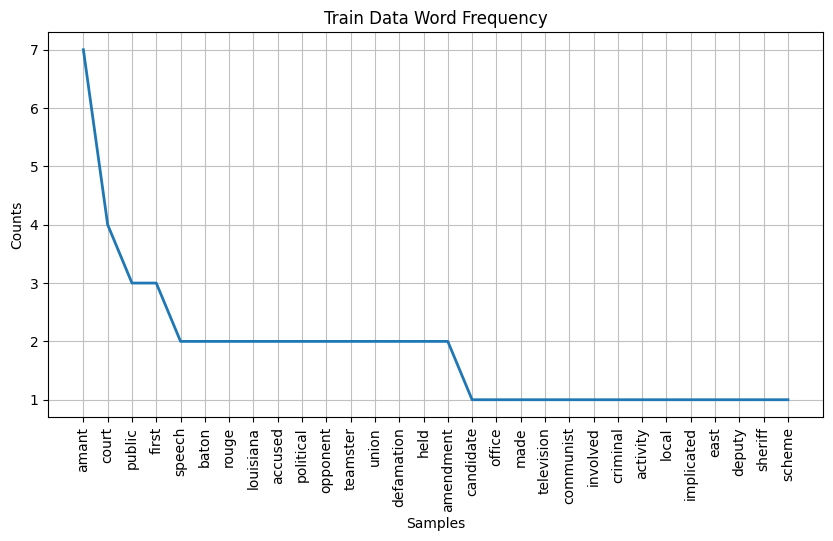

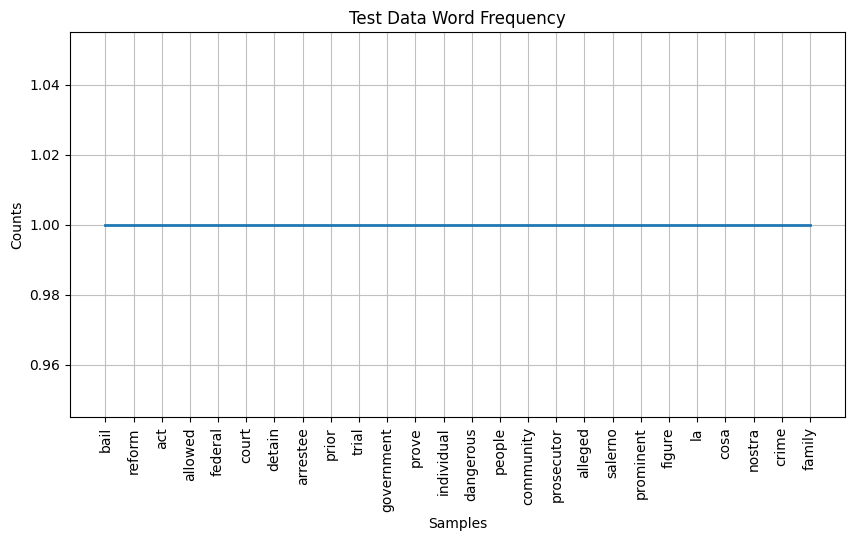

In [11]:
train_freq_dist_list = []

for i in cleaned_df['facts']:
    # 학습 데이터의 단어 빈도
    train_tokens = nltk.word_tokenize(i)  # train_data는 학습 데이터의 텍스트
    train_freq_dist = FreqDist(train_tokens)
    train_freq_dist_list.append(train_freq_dist)
    
test_freq_dist_list = []
for i in test_cleaned_df['facts']:
    # 테스트 데이터의 단어 빈도
    test_tokens = nltk.word_tokenize(i)  # test_data는 테스트 데이터의 텍스트
    test_freq_dist = FreqDist(test_tokens)
    test_freq_dist_list.append(test_freq_dist)
    
# 단어 빈도 그래프 비교
plt.figure(figsize=(10, 5))
train_freq_dist_list[0].plot(30, title='Train Data Word Frequency')
plt.figure(figsize=(10, 5))
test_freq_dist_list[0].plot(30, title='Test Data Word Frequency')
plt.show()

In [12]:
train_result_dict = {}
for i in train_freq_dist_list:
    train_result_dict.update(i)

test_result_dict = {}
for q in test_freq_dist_list:
    test_result_dict.update(q)

In [13]:
dict(sorted(train_result_dict.items(), key=lambda x: x[1], reverse=True))

{'lange': 24,
 'lucky': 21,
 'sealy': 19,
 'taggart': 17,
 'clair': 16,
 'muniz': 16,
 'howard': 15,
 'mandel': 15,
 'lozman': 14,
 'romag': 14,
 'amtrak': 13,
 'hyatt': 13,
 'jeffers': 13,
 'titlow': 13,
 'beaudreaux': 13,
 'brumfield': 13,
 'ftb': 13,
 'pension': 12,
 'petrella': 12,
 'ake': 12,
 'apple': 12,
 'bostock': 12,
 'hawaiian': 12,
 'scout': 12,
 'tazewell': 12,
 'bm': 12,
 'eddings': 12,
 'pennsylvania': 11,
 'shuttlesworth': 11,
 'slack': 11,
 'kirkpatrick': 11,
 'hoeper': 11,
 'pointer': 11,
 'barefoot': 11,
 'medellin': 11,
 'beilan': 11,
 'sylvania': 11,
 'metlife': 11,
 'bbi': 10,
 'amgen': 10,
 'navajo': 10,
 'teale': 10,
 'pereida': 10,
 'vartelas': 10,
 'wonderful': 10,
 'coca': 10,
 'ifc': 10,
 'fhfa': 10,
 'maslenjak': 10,
 'cochise': 10,
 'raisin': 10,
 'mullenix': 10,
 'carle': 10,
 'blueford': 10,
 'burbine': 10,
 'vogt': 10,
 'depot': 9,
 'byars': 9,
 'skokie': 9,
 'morrissey': 9,
 'rompilla': 9,
 'spano': 9,
 'solvay': 9,
 'adcock': 9,
 'kaleys': 9,
 'ritz':

In [14]:
dict(sorted(test_result_dict.items(), key=lambda x: x[1], reverse=True))

{'hammer': 16,
 'minnick': 15,
 'ritzen': 14,
 'kaupp': 14,
 'wetland': 13,
 'booking.com': 12,
 'taxpayer': 12,
 'stauffer': 12,
 'cuero': 12,
 'montanile': 12,
 'gipson': 11,
 'cwa': 11,
 'guam': 11,
 'mincey': 11,
 'sudan': 11,
 'generes': 10,
 'papai': 10,
 'rothgery': 9,
 'pg': 9,
 'dobbert': 9,
 'concrete': 9,
 'intel': 9,
 'directorate': 9,
 'corp': 9,
 'navigable': 9,
 'bagley': 9,
 'psd': 9,
 'medicare': 9,
 'advocate': 9,
 'cone': 9,
 'judulang': 9,
 'stansbury': 9,
 'trail': 8,
 'lonchar': 8,
 'bp': 8,
 'abrams': 8,
 'mirzayance': 8,
 'vieques': 8,
 'prime': 8,
 'hishon': 8,
 'medtronic': 8,
 'funeral': 8,
 'kirtsaeng': 8,
 'aereo': 8,
 'c235': 8,
 'cpea': 8,
 'weisgram': 8,
 'rotkiske': 8,
 'gene': 8,
 'centennial': 7,
 'carrier': 7,
 'stryker': 7,
 'zimmer': 7,
 'felony': 7,
 'powerex': 7,
 'tolan': 7,
 'bankruptcy': 7,
 'appling': 7,
 'software': 7,
 'bradstreet': 7,
 'greenmoss': 7,
 'pda': 7,
 'ftb': 7,
 'chevron': 7,
 'leegin': 7,
 'siebert': 7,
 'scarpelli': 7,
 'jeri

In [15]:
set_train_freq_dist_list=[]
train_word_list = []
for i in train_freq_dist_list:
    set_train_freq_dist_list.append(set(i))

for q in range(len(set_train_freq_dist_list)):
    for i in set_train_freq_dist_list[q]:
        train_word_list.append(i)
len(train_word_list)

151149

In [16]:
set_test_freq_dist_list=[]
test_word_list = []
for i in test_freq_dist_list:
    set_test_freq_dist_list.append(set(i))

for q in range(len(set_test_freq_dist_list)):
    for i in set_test_freq_dist_list[q]:
        test_word_list.append(i)
len(test_word_list)

75732

In [17]:
def check_overlap(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    overlap = set1.intersection(set2)
    if overlap:
        return True
    else:
        return False

# 두 개의 리스트

# 겹치는지 확인
is_overlap = check_overlap(train_word_list, test_word_list)

if is_overlap:
    print("두 리스트에 겹치는 단어가 있습니다.")
else:
    print("두 리스트에 겹치는 단어가 없습니다.")

두 리스트에 겹치는 단어가 있습니다.


In [18]:
def get_overlap_words(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    overlap = set1.intersection(set2)
    return list(overlap)

# 두 개의 리스트


# 겹치는 단어들 출력
overlap_words = get_overlap_words(train_word_list, test_word_list)
print("겹치는 단어들:", len(overlap_words))

겹치는 단어들: 5230


In [19]:
overlap_train = {}
for i in overlap_words:
    print(i, train_result_dict[i])
    overlap_train[i] = train_result_dict[i]

fence 1
party 1
disorder 1
paternity 3
expression 1
opted 1
prolong 1
lunch 1
consisted 1
a.k.a 1
igra 2
advertisement 3
minimum 1
fifty 1
represent 3
reader 2
meanwhile 1
cited 1
furnished 1
tailored 1
intentional 2
safley 2
bred 1
cure 2
narcotic 1
division 1
girlfriend 1
noted 1
lynaugh 1
cromartie 2
hhs 2
intrastate 3
equivalent 2
taxing 1
conventional 1
stopping 1
obligated 1
carry 1
prong 1
displaying 1
breaking 1
developmental 1
mccarran 2
ineffective 2
concede 1
protocol 1
manhattan 3
petitioner 1
directing 1
resigned 1
author 1
floorboard 1
acca 1
combat 1
molestation 1
bay 1
conducted 1
concurrent 1
loaded 1
mobile 1
offset 1
altitude 1
audio 2
liquor 3
fifth 1
execute 1
fabrication 1
calif. 1
bartender 1
distinct 2
kill 1
advice 1
influencing 1
done 1
adequacy 1
boat 2
road 1
abstain 1
handle 1
chaplain 1
ct 7
priority 2
true 1
ssi 1
mandate 1
inclined 1
occurs 1
registering 2
wiretap 4
concession 4
witherspoon 3
insolvency 1
item 1
tank 4
afcca 2
hotel 2
plra 2
multidistric

In [20]:
overlap_test = {}
for i in overlap_words:
    print(i, test_result_dict[i])
    overlap_test[i] = test_result_dict[i]

fence 1
party 1
disorder 1
paternity 1
expression 1
opted 1
prolong 1
lunch 1
consisted 1
a.k.a 1
igra 1
advertisement 3
minimum 2
fifty 1
represent 1
reader 1
meanwhile 1
cited 1
furnished 1
tailored 1
intentional 2
safley 1
bred 1
cure 2
narcotic 1
division 1
girlfriend 1
noted 1
lynaugh 1
cromartie 2
hhs 1
intrastate 2
equivalent 1
taxing 1
conventional 1
stopping 1
obligated 1
carry 1
prong 2
displaying 1
breaking 1
developmental 1
mccarran 1
ineffective 1
concede 1
protocol 1
manhattan 1
petitioner 1
directing 1
resigned 1
author 1
floorboard 1
acca 4
combat 1
molestation 1
bay 2
conducted 1
concurrent 1
loaded 1
mobile 1
offset 1
altitude 1
audio 1
liquor 1
fifth 1
execute 1
fabrication 1
calif. 1
bartender 1
distinct 1
kill 2
advice 1
influencing 2
done 1
adequacy 1
boat 4
road 3
abstain 3
handle 1
chaplain 1
ct 1
priority 2
true 3
ssi 2
mandate 6
inclined 1
occurs 1
registering 1
wiretap 3
concession 3
witherspoon 1
insolvency 1
item 2
tank 1
afcca 1
hotel 3
plra 3
multidistric

In [21]:
dict(sorted(overlap_train.items(), key=lambda x: x[1], reverse=True))

{'clair': 16,
 'hyatt': 13,
 'amtrak': 13,
 'ftb': 13,
 'apple': 12,
 'hawaiian': 12,
 'pension': 12,
 'pennsylvania': 11,
 'navajo': 10,
 'raisin': 10,
 'socket': 9,
 'photo': 8,
 'rural': 8,
 'cwa': 8,
 'wrtl': 8,
 'icon': 8,
 'zenith': 8,
 'kirtsaeng': 8,
 'ct': 7,
 'k': 7,
 'trailer': 7,
 'precinct': 7,
 'continental': 7,
 'forsyth': 7,
 'homosexual': 7,
 'tribal': 7,
 'copyright': 7,
 'retiree': 7,
 'seed': 7,
 'oxford': 7,
 'alj': 6,
 'farm': 6,
 'pg': 6,
 'benefit': 6,
 'fiore': 6,
 'pharmacist': 6,
 'entergy': 6,
 'credit': 6,
 'top': 6,
 'trademark': 6,
 'debt': 6,
 'captain': 6,
 'mohawk': 6,
 'abortion': 6,
 'ge': 6,
 'card': 6,
 'investigation': 6,
 'mr.': 6,
 'plan': 6,
 'applicant': 6,
 'bare': 6,
 'cone': 6,
 'fire': 6,
 'colorado': 6,
 'gun': 6,
 'jurisdiction': 6,
 'f.': 6,
 'scholarship': 6,
 'iphone': 6,
 'shoe': 6,
 'carrier': 6,
 'diminished': 6,
 'state': 6,
 'reopen': 6,
 'advanced': 6,
 'conrail': 6,
 'fcra': 6,
 'usa': 6,
 'dppa': 6,
 'village': 5,
 'supreme': 

In [22]:
dict(sorted(overlap_test.items(), key=lambda x: x[1], reverse=True))

{'wetland': 13,
 'taxpayer': 12,
 'guam': 11,
 'cwa': 11,
 'navigable': 9,
 'pg': 9,
 'intel': 9,
 'corp': 9,
 'medicare': 9,
 'cone': 9,
 'concrete': 9,
 'advocate': 9,
 'funeral': 8,
 'medtronic': 8,
 'trail': 8,
 'prime': 8,
 'kirtsaeng': 8,
 'appling': 7,
 'software': 7,
 'felony': 7,
 'chevron': 7,
 'ftb': 7,
 'ftc': 7,
 'carrier': 7,
 'bankruptcy': 7,
 'fmla': 7,
 'mandate': 6,
 'mena': 6,
 'dwelling': 6,
 'dangerousness': 6,
 'alaska': 6,
 'crow': 6,
 'monsanto': 6,
 'summons': 6,
 'preclearance': 6,
 'consortium': 6,
 'mohawk': 6,
 'iran': 6,
 'iranian': 6,
 'motel': 6,
 'court': 6,
 'port': 6,
 'zenith': 6,
 'ata': 6,
 'cable': 6,
 'tax': 6,
 'epa': 6,
 'exploration': 6,
 'team': 6,
 'conrail': 6,
 'deadline': 5,
 'ms.': 5,
 'hawaii': 5,
 'nominee': 5,
 'advertising': 5,
 'identification': 5,
 'pregnancy': 5,
 'tug': 5,
 'f': 5,
 'extradition': 5,
 'casino': 5,
 'claimant': 5,
 'note': 5,
 'fee': 5,
 'contraceptive': 5,
 'delta': 5,
 'education': 5,
 'japanese': 5,
 'malicious

In [23]:
# 겹치는단어 분포
pos_tags = nltk.pos_tag(overlap_words)

# 품사 태그들의 분포 확인
tag_counts = Counter(tag for word, tag in pos_tags)

# 분포 출력
for tag, count in tag_counts.items():
    print(f"{tag}: {count}")

NN: 2450
VBD: 467
JJ: 1235
RB: 75
VBN: 258
VBG: 447
VBP: 84
VB: 25
RP: 2
FW: 6
VBZ: 31
IN: 21
NNS: 86
JJR: 13
CD: 4
JJS: 8
RBR: 8
.: 1
NNP: 7
CC: 1
PRP: 1


In [24]:
# 겹치는단어 분포
# 품사 태그들을 동사(VB), 명사(NN), 형용사(JJ)로 묶어서 카운트
pos_tag_counts = Counter()
for word, tag in pos_tags:
    if tag.startswith('V'):
        pos_tag_counts['V'] += 1
    elif tag.startswith('N'):
        pos_tag_counts['N'] += 1
    elif tag.startswith('J'):
        pos_tag_counts['J'] += 1

# 개별 품사 태그들과 해당 태그들의 개수 출력
for tag, count in pos_tag_counts.items():
    print(f"{tag}: {count}")

# 총 개수 출력
total_count = sum(pos_tag_counts.values())
print(f"Total Count: {total_count}")

N: 2543
V: 1312
J: 1256
Total Count: 5111


In [25]:
pos_tags_te = []

In [26]:
for i in pos_tags:
    if i[1][0] == 'N' or i[1][0] == 'V' or i[1][0] == 'J':
        pos_tags_te.append(i[0])

In [27]:
for i in range(len(pos_tags_te)):
    if pos_tags_te[i] == 'ph':
        print(i)

2549


In [28]:
pos_tags_te.remove('ph')

In [29]:
for i in pos_tags_te:
    if len(i) ==2:
        pos_tags_te.remove(i)

In [30]:
# train
te_pos_tags = nltk.pos_tag(pos_tags_te)

# 품사 태그들의 분포 확인
te_tag_counts = Counter(tag for word, tag in te_pos_tags)

# 분포 출력
for tag, count in te_tag_counts.items():
    print(f"{tag}: {count}")

NN: 2427
VBD: 476
JJ: 1233
VBG: 444
VBN: 239
VB: 24
VBP: 77
VBZ: 31
NNS: 85
JJR: 13
RB: 3
JJS: 8
IN: 3
NNP: 6
RBR: 1


In [31]:
# train
train_pos_tags = nltk.pos_tag(train_word_list)

# 품사 태그들의 분포 확인
train_tag_counts = Counter(tag for word, tag in train_pos_tags)

# 분포 출력
for tag, count in train_tag_counts.items():
    print(f"{tag}: {count}")

NN: 74977
JJ: 32100
VBD: 16958
NNS: 1737
VBN: 10455
VB: 868
VBG: 8473
RB: 1679
VBP: 1573
RBR: 165
JJS: 137
IN: 526
NNP: 160
VBZ: 716
JJR: 292
RP: 38
FW: 115
POS: 5
CD: 58
WDT: 10
CC: 20
.: 20
PRP$: 2
WP: 6
DT: 6
PRP: 39
WRB: 6
MD: 7
RBS: 1


In [32]:
# test
test_pos_tags = nltk.pos_tag(test_word_list)

# 품사 태그들의 분포 확인
test_tag_counts = Counter(tag for word, tag in test_pos_tags)

# 분포 출력
for tag, count in test_tag_counts.items():
    print(f"{tag}: {count}")

NN: 37406
JJ: 16170
VBN: 5262
VBD: 8453
FW: 50
RB: 903
NNS: 854
VBP: 878
VBG: 4191
VBZ: 402
RP: 14
JJR: 122
VB: 419
IN: 247
CD: 41
NNP: 77
JJS: 96
PRP: 20
EX: 2
RBR: 98
MD: 7
POS: 2
.: 6
WDT: 4
CC: 5
NNPS: 2
WRB: 1


In [33]:
# train 동사 명사 형용사
train_pos_tags = nltk.pos_tag(train_word_list)

# 품사 태그들 중 명사(N), 동사(V), 형용사(J) 카운트
train_tag_counts = Counter(tag for word, tag in train_pos_tags if tag.startswith('N') or tag.startswith('V') or tag.startswith('J'))

# 분포 출력
for tag, count in train_tag_counts.items():
    print(f"{tag}: {count}")

NN: 74977
JJ: 32100
VBD: 16958
NNS: 1737
VBN: 10455
VB: 868
VBG: 8473
VBP: 1573
JJS: 137
NNP: 160
VBZ: 716
JJR: 292


In [34]:
# train
# 품사 태그들을 동사(VB), 명사(NN), 형용사(JJ)로 묶어서 카운트
train_tag_counts = Counter()
for word, tag in train_pos_tags:
    if tag.startswith('V'):
        train_tag_counts['V'] += 1
    elif tag.startswith('N'):
        train_tag_counts['N'] += 1
    elif tag.startswith('J'):
        train_tag_counts['J'] += 1

# 개별 품사 태그들과 해당 태그들의 개수 출력
for tag, count in train_tag_counts.items():
    print(f"{tag}: {count}")

# 총 개수 출력
total_count = sum(train_tag_counts.values())
print(f"Total Count: {total_count}")

N: 76874
J: 32529
V: 39043
Total Count: 148446


In [35]:
# test
test_pos_tags = nltk.pos_tag(test_word_list)

# 품사 태그들 중 명사(NN), 동사(VB), 형용사(JJ) 카운트
test_tag_counts = Counter(tag for word, tag in test_pos_tags if tag.startswith('N') or tag.startswith('V') or tag.startswith('J'))

# 분포 출력
for tag, count in test_tag_counts.items():
    print(f"{tag}: {count}")

NN: 37406
JJ: 16170
VBN: 5262
VBD: 8453
NNS: 854
VBP: 878
VBG: 4191
VBZ: 402
JJR: 122
VB: 419
NNP: 77
JJS: 96
NNPS: 2


In [36]:
# test
# 품사 태그들을 동사(VB), 명사(NN), 형용사(JJ)로 묶어서 카운트
test_tag_counts = Counter()
for word, tag in test_pos_tags:
    if tag.startswith('V'):
        test_tag_counts['V'] += 1
    elif tag.startswith('N'):
        test_tag_counts['N'] += 1
    elif tag.startswith('J'):
        test_tag_counts['J'] += 1

# 개별 품사 태그들과 해당 태그들의 개수 출력
for tag, count in test_tag_counts.items():
    print(f"{tag}: {count}")

# 총 개수 출력
total_count = sum(test_tag_counts.values())
print(f"Total Count: {total_count}")

N: 38339
J: 16388
V: 19605
Total Count: 74332


In [37]:
train_tag_counts

Counter({'N': 76874, 'J': 32529, 'V': 39043})

In [38]:
test_tag_counts

Counter({'N': 38339, 'J': 16388, 'V': 19605})

## Define Model & Train

In [39]:
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [52]:
vectorizer = TfidfVectorizer( max_features=10000, max_df=15, ngram_range=(1,2), vocabulary=overlap_words)

# 
X_train = get_vector(vectorizer, cleaned_df, True)
Y_train = train["first_party_winner"]
X_test = get_vector(vectorizer, test_cleaned_df, False)

# 코사인 유사도 계산
similarity = cosine_similarity(X_train, X_test)

print("코사인 유사도:", similarity[0][0])        

# 언더샘플링 수행
rus = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X_train, Y_train)

# SMOTE 오버샘플링 적용 (k_neighbors 파라미터 조절)
smote = SMOTE(k_neighbors=2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_undersampled, y_undersampled)

# 언더샘플링과 SMOTE 오버샘플링을 거친 후
X_train, X_val, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# train 데이터와 val데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = LogisticRegression(solver='newton-cg', C=1.0, verbose=2, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# 정확도를 계산하여 출력합니다.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

코사인 유사도: 0.034181728440276754


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished


Accuracy: 0.7221418234442837


In [41]:
submit = pd.read_csv('./sample_submission.csv')

pred = model.predict(X_test)

submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')

Done
